In [119]:
import re
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr 
from pathlib import Path
import scipy.linalg as LA
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

sys.path.append('../../src/plotting')
from plot_spinup import make_colorbar, plot_volume

# Set global matplotlib style parameters
plt.rcParams.update({'text.usetex': True, 
                     'animation.html': 'jshtml', 
                     'figure.facecolor': 'w', 
                     'savefig.bbox':'tight'})

def calc_perc_temp(src): 
    # number of valid nodes above minimum ice-thickness
    NN = src.height.where(src.height < 10).count(dim=('coord_1', 'coord_2'))
    # mask for determining where nodes are temperate 
    mask = src['enthalpy_h'] > src['phase change enthalpy']
    # number of nodes where ethalpy exceeds phase chnage enthalpy
    NT = src.enthalpy_h.where(mask).count(dim=('coord_1', 'coord_2'))
    return NT/NN * 100

def make_colorbar(mf_dataset):
    #---------------------------------------------------------------------------
    # For Seting up the colorbar:
    #    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
    #---------------------------------------------------------------------------
    cmap = cm.plasma
    norm = mcolors.Normalize(vmin=np.min(mf_dataset.Delta_MB.values),
                             vmax=np.max(mf_dataset.Delta_MB.values))

    s_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    s_map.set_array(np.linspace(mf_dataset.Delta_MB.values.min(),
                                mf_dataset.Delta_MB.values.max(),
                                mf_dataset.Delta_MB.size+1))

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (mf_dataset.Delta_MB[1] - mf_dataset.Delta_MB[0]) / 2.0
    bounds   = np.linspace(mf_dataset.Delta_MB.values.min()  - halfdist,
                           mf_dataset.Delta_MB.values.max()  + halfdist,
                           len(mf_dataset.Delta_MB) + 2)

    return cmap, norm, s_map, bounds

# converts quad elements into tri elements
def quads_to_tris(quads):
    tris = [[None for j in range(3)] for i in range(2*len(quads))]
    for i in range(len(quads)):
        j = 2*i
        n0 = quads[i][0]
        n1 = quads[i][1]
        n2 = quads[i][2]
        n3 = quads[i][3]
        tris[j][0] = n0
        tris[j][1] = n1
        tris[j][2] = n2
        tris[j + 1][0] = n2
        tris[j + 1][1] = n3
        tris[j + 1][2] = n0
    return tris

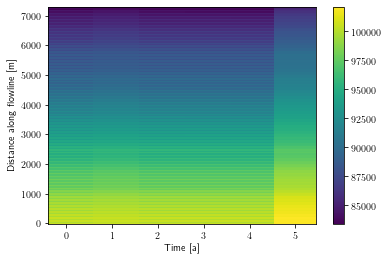

In [129]:
src_fp   = "glc1-a/nc/glc1-a_dx_50_MB_-1.000_OFF_prog.nc"
with xr.open_dataset(src_fp) as src: 
    src["height"] = xr.where(src.height <= 10, 0, src.height)
    src["Z"]     = src.zbed + src.Z * src.height 
    src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)
    
    
plt.pcolormesh(src.t, 
               src.coord_1,
               src['surface_enthalpy'].isel(coord_2=-1).T, 
               shading='auto')


plt.ylabel('Distance along flowline [m]')
plt.xlabel('Time [a]')

plt.colorbar()

0.1
1.0999999999999999
2.1000000000000005


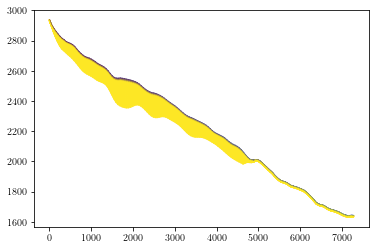

In [126]:
triangles = quads_to_tris(src.Mesh_face_nodes.values - 1)

for time in src.isel(time=[0, 10, 20]).time.values: 
    print(time)
    
    # plot the contours
    plt.tripcolor(src.Mesh_node_x[::-1], 
                  src.Mesh_node_y.sel(time=time), 
                  triangles, 
                  src['surface_enthalpy'].sel(time=time), 
                  shading='gouraud', 
                  alpha=0.5)


In [142]:
src_fp   = "glc1-a/nc/glc1-a_dx_50_MB_-1.000_OFF_prog.nc"
with xr.open_dataset(src_fp) as src: 
    src["height"] = xr.where(src.height <= 10, 0, src.height)
    src["Z"]     = src.zbed + src.Z * src.height 
    src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)
    
    src.load()
    
Vol = src.height.isel(coord_2=-1).integrate("coord_1") /\
      src.height.isel(coord_2=-1).isel(t=0).integrate("coord_1")


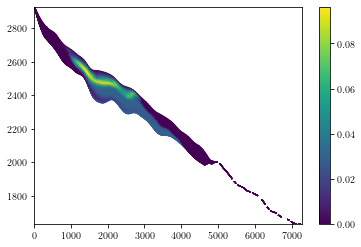

In [143]:
fig, ax = plt.subplots()

im = ax.pcolormesh(src.X[::-1], src.Z.isel(t=-1), 
                   src['water content'].isel(t=slice(-10,-1)).mean('t'), 
               shading='gouraud')

fig.colorbar(im)

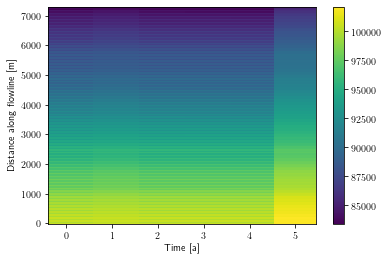

In [144]:
plt.pcolormesh(src.t, 
               src.coord_1,
               src['surface_enthalpy'].isel(coord_2=-1).T, 
               shading='auto')


plt.ylabel('Distance along flowline [m]')
plt.xlabel('Time [a]')

plt.colorbar()

plt.savefig('/Users/andrewnolan/Desktop/surface_enthalpy_local.png', dpi=400)

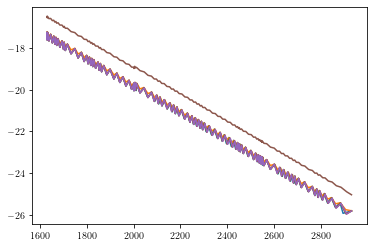

In [145]:
for t in src.t: 
    # plt.plot(src.coord_1[::-1], src['surface_enthalpy'].isel(coord_2=-1).rolling(t=10).mean().sel(t=t))
    plt.plot(src.Z.isel(coord_2=-1).sel(t=t), 
             calc_temp(src['surface_enthalpy'].isel(coord_2=-1).sel(t=t))
              # src['surface_enthalpy'].isel(coord_2=-1).sel(t=t)
             )

In [8]:
# # for t in src.t: 
# #     # plt.plot(src.coord_1[::-1], src['surface_enthalpy'].isel(coord_2=-1).rolling(t=10).mean().sel(t=t))
# #     plt.plot(src.Z.isel(coord_2=-1).sel(t=t), 
# #              calc_temp(src['surface_enthalpy'].isel(coord_2=-1).sel(t=t))
# #               # src['surface_enthalpy'].isel(coord_2=-1).sel(t=t)
# #              )
# plt.plot(src.Z.isel(coord_2=-1).sel(t=t),
#          calc_temp(src['surface_enthalpy'].isel(coord_2=-1).mean('t')))

# plt.axhline(0, ls=":", c='k')
    
# plt.plot(localrun_m9.Z.isel(coord_2=-1,Delta_MB=0).sel(t=t), 
#          calc_temp(localrun_m9['surface_enthalpy'].isel(t=5,Delta_MB=0,coord_2=-1))
#          # localrun_m9['surface_enthalpy'].isel(t=5,Delta_MB=0,coord_2=-1)
#         )

In [7]:
# idx = np.argpartition(np.abs(localrun_m9.Z.isel(coord_2=-1,Delta_MB=0).sel(t=t) - 2193), 5)[:5].values

In [9]:
# calc_temp(localrun_m9['surface_enthalpy'].isel(t=5,Delta_MB=0,coord_2=-1))[idx]

In [10]:
def calc_temp(H, T_ref=200, A=7.253, B=146.3): 
    return (-B + (B**2 + 2*A*((A/2)*T_ref**2 + B*T_ref + H))**(1/2)) / A - 273.15

In [ ]:
fig, anim = animate_Zs.animate_2D_field(src, 
                                        field=["vel_m", "temperature"],
                                        title="$\Delta \dot b$ = {:.3f}".format(Delta_mb),
                                        cbar_label=['Velocity [m a$^{-1}$]', 'Temperature [C]'],
                                        vmin=[0, -12.5], 
                                        vmax=[25, 0.0], 
                                        cmap=['viridis', 'plasma'],
                                        stride=1, 
                                        interval=100)

plt.close()

anim.save(f'./figs/local_test_anim.mp4')

In [136]:
drive_fp = Path("/Volumes/thermal/Thesis/thermal-structure/study/coupled_init/")
src_fp   = drive_fp / "glc1-a/nc/glc1-a_dx_50_NT_20000_dt_0.1_MB_-1.500_OFF_prog.nc"

In [137]:
with xr.open_dataset(src_fp) as src: 
    src["height"] = xr.where(src.height <= 10, 0, src.height)
    src["Z"]     = src.zbed + src.Z * src.height 
    src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)
    
    src.load()
    
Vol = src.height.isel(coord_2=-1).integrate("coord_1") /\
      src.height.isel(coord_2=-1).isel(t=0).integrate("coord_1")


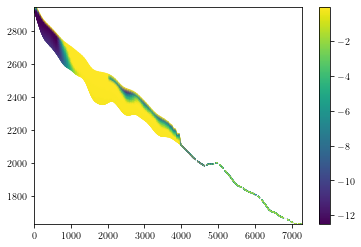

In [138]:
fig, ax = plt.subplots()

im = ax.pcolormesh(src.X[::-1], src.Z.isel(t=-1), 
               src['temperature'].isel(t=0), 
               shading='gouraud', 
                vmin=-12.5)

fig.colorbar(im)

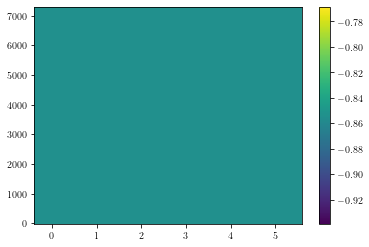

In [141]:
plt.pcolormesh(src.t[:6], 
               src.coord_1,
               calc_temp(src['surface_enthalpy'].isel(coord_2=-1,t=slice(0,6))).T, 
               shading='auto')


plt.colorbar()

# plt.savefig('/Users/andrewnolan/Desktop/temp_node-2.png', dpi=400)

In [117]:
src

<xarray.Dataset>
Dimensions:                  (coord_1: 147, coord_2: 16, t: 2001)
Coordinates:
  * coord_1                  (coord_1) float32 0.0 49.86 ... 7.23e+03 7.28e+03
  * coord_2                  (coord_2) float32 0.0 0.06667 0.1333 ... 0.9333 1.0
  * t                        (t) float32 0.1 1.1 2.1 ... 1.999e+03 2e+03
Data variables:
    X                        (coord_1, coord_2) float32 0.0 0.0 ... 7.28e+03
    Z                        (t, coord_1, coord_2) float32 1.632e+03 ... 2.93...
    NN                       (coord_1, coord_2) int32 1 148 295 ... 2205 2352
    zbed                     (t, coord_1, coord_2) float32 1.632e+03 ... 2.93...
    mass balance             (t, coord_1, coord_2) float32 0.0 0.0 ... 0.0 1.861
    surface_enthalpy         (t, coord_1, coord_2) float32 1.344e+05 ... 8.52...
    densi                    (t, coord_1, coord_2) float32 910.0 910.0 ... 350.0
    w                        (t, coord_1, coord_2) float32 4.134e-06 ... 0.00...
    velocity 1               (t, coord_1, coord_2) float32 0.0 ... -1.085
    velocity 2               (t, coord_1, coord_2) float32 0.0 ... -0.3317
    pressure                 (t, coord_1, coord_2) float32 0.09243 ... -0.05266
    mesh velocity 1          (t, coord_1, coord_2) float32 0.0 0.0 ... 0.0 0.0
    mesh velocity 2          (t, coord_1, coord_2) float32 0.0 0.0 ... 0.0 0.0
    enthalpy_h               (t, coord_1, coord_2) float32 1.232e+05 ... 8.51...
    phase change enthalpy    (t, coord_1, coord_2) float32 1.344e+05 ... 1.34...
    water content            (t, coord_1, coord_2) float32 0.0 0.0 ... 0.0 0.0
    temperature              (t, coord_1, coord_2) float32 -5.389 ... -24.48
    enthalpy_h contact load  (t, coord_1, coord_2) float32 2.881e+05 ... -2.6...
    zs                       (t, coord_1, coord_2) float32 2.881e+05 ... 2.94...
    zs residual              (t, coord_1, coord_2) float32 0.0 0.0 ... 0.0 57.91
    refzs                    (t, coord_1, coord_2) float32 0.0 0.0 ... 2.93e+03
    zs accumulation flux 2   (t, coord_1, coord_2) float32 0.0 0.0 ... 0.0 1.861
    depth                    (t, coord_1, coord_2) float32 10.0 9.333 ... 0.0
    height                   (t, coord_1, coord_2) float32 0.0 0.0 ... 0.0 0.0
    vel_m                    (t, coord_1, coord_2) float32 0.0 ... 1.135

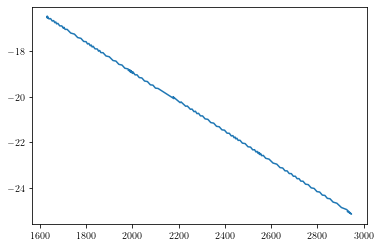

In [80]:
plt.plot(src.Z.isel(t=-1, coord_2=-1), calc_temp(src['surface_enthalpy'].isel(coord_2=-1, t=-1)))

In [18]:
perc = calc_perc_temp(src)

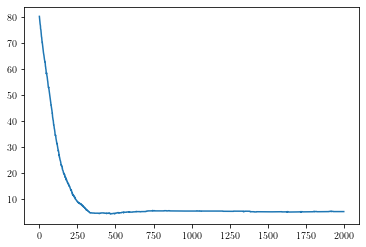

In [19]:
plt.plot(perc.t[:-1], perc[:-1]) 

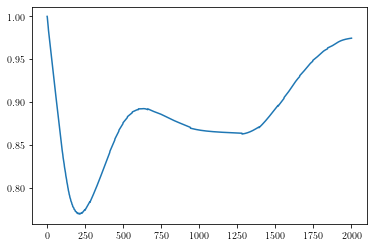

In [20]:
plt.plot(Vol.t, Vol)

In [21]:
def load_diagnostic(fps:list):
    """
    """
    
    fps   = sorted(glob.glob(fps))
    match = re.search('MB_-*\d*\d\.\d*\d_OFF', fps[0])
    
    if match: 
        fps.sort(key = lambda x: float(x.split('MB_')[-1].split('_OFF')[0]),
               reverse = True)
        offsets = [float(x.split('MB_')[-1].split('_OFF')[0]) for x in fps]
    else: 
        raise re.error('pattern not found')
    

    def process_one_path(path, offsets): 
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataset(path) as ds:
            ds = ds.expand_dims("Delta_MB").assign_coords(Delta_MB=('Delta_MB', [offsets]))
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
        return ds    
    
    datasets = []  
    for fp, off in zip(fps, offsets): 
        datasets.append(process_one_path(fp, off))

    # Concatenate the files
    combined = xr.concat(datasets, "Delta_MB")
    
    # do some preproccessing of the files
    combined["height"] = xr.where(combined.height <= 10, 0, combined.height)
    combined["Z"]     = combined.zbed + combined.Z * combined.height 
    combined['vel_m'] = np.sqrt(combined['velocity 1']**2 + combined['velocity 2']**2)

    return combined 


def find_Tf(field): 
    
    # field = combined.Z.isel(coord_1=-1, coord_2=-1)

    t_f = field.where(~np.isnan(field)).count('t')
    
    return t_f

In [38]:
cd /Volumes/thermal/Thesis/thermal-structure/study/coupled_init/

/Volumes/thermal/Thesis/thermal-structure/study/coupled_init


In [39]:
pwd

'/Volumes/thermal/Thesis/thermal-structure/study/coupled_init'

In [40]:
prognostic = load_diagnostic("glc1-a/nc/*prog.nc")

In [41]:
prog_vol = prognostic.height.isel(coord_2=-1).integrate("coord_1") /\
           prognostic.height.isel(coord_2=-1).isel(t=0).integrate("coord_1")

prog_perc = calc_perc_temp(prognostic)

In [42]:
cd ~/Thesis/thermal-structure/study/coupled_init/

/Users/andrewnolan/Thesis/thermal-structure/study/coupled_init


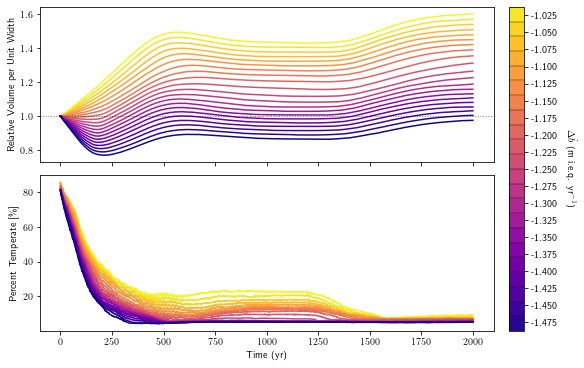

In [61]:
cmap, norm, s_map, bounds = make_colorbar(prognostic)

fig, ax = plt.subplots(2,1, figsize=(8,5), sharex=True,
                       constrained_layout=True)

for offset in prog_vol.Delta_MB.values: 
    color = cmap(norm(offset))
    
    # Plot Volume 
    ax[0].plot(prog_vol.t, prog_vol.sel(Delta_MB=offset), color = color)
    
    # Plot % temperate
    ax[1].plot(prog_perc.t[:-1], prog_perc.sel(Delta_MB=offset)[:-1], color = color)
    
    # ax[1].plot(prognostic.coord_1, prognostic.sel(Delta_MB=offset).isel(t=-1, coord_2=-1).Z, color = color)
    
# ax[1].plot(prognostic.coord_1, prognostic.sel(Delta_MB=offset).isel(t=0, coord_2=-1).Z, color = 'k')

ax[0].axhline(1.0,c='k',ls=':',lw=1, alpha=0.5)

cbar = fig.colorbar(s_map,
                    spacing='proportional',
                    ticks=np.linspace(prog_vol.Delta_MB.values.min(),
                                      prog_vol.Delta_MB.values.max(),
                                      prog_vol.Delta_MB.size),
                    ax=ax,
                    boundaries=bounds,
                    drawedges=True,
                    format='%2.{}f'.format(3),
                    aspect=35)


# annotate the figures axes
ax[0].set_ylabel('Relative Volume per Unit Width')
ax[1].set_ylabel('Percent Temperate [\%]')
ax[1].set_xlabel('Time (yr)')
# annotate the colorbar axes
cbar.set_label('$\Delta \dot b$ (m i.e.q. yr$^{-1}$)', rotation=270, labelpad=20)
#cbar.ax.tick_params(labelsize=7)


fig.savefig('./figs/Vol_PercTemp_2kya.png', dpi=300)

In [44]:
np.linspace(prog_vol.Delta_MB.values.min(),
                                      prog_vol.Delta_MB.values.max(),
                                      prog_vol.Delta_MB.size+1)

array([-1.5       , -1.47619048, -1.45238095, -1.42857143, -1.4047619 ,
       -1.38095238, -1.35714286, -1.33333333, -1.30952381, -1.28571429,
       -1.26190476, -1.23809524, -1.21428571, -1.19047619, -1.16666667,
       -1.14285714, -1.11904762, -1.0952381 , -1.07142857, -1.04761905,
       -1.02380952, -1.        ])

In [45]:
prog_vol.Delta_MB

<xarray.DataArray 'Delta_MB' (Delta_MB: 21)>
array([-1.   , -1.025, -1.05 , -1.075, -1.1  , -1.125, -1.15 , -1.175, -1.2  ,
       -1.225, -1.25 , -1.275, -1.3  , -1.325, -1.35 , -1.375, -1.4  , -1.425,
       -1.45 , -1.475, -1.5  ])
Coordinates:
    coord_2   float32 1.0
  * Delta_MB  (Delta_MB) float64 -1.0 -1.025 -1.05 -1.075 ... -1.45 -1.475 -1.5

In [46]:
np.arange(-1.5, -0.975, 0.025)[::-1]

array([-1.   , -1.025, -1.05 , -1.075, -1.1  , -1.125, -1.15 , -1.175,
       -1.2  , -1.225, -1.25 , -1.275, -1.3  , -1.325, -1.35 , -1.375,
       -1.4  , -1.425, -1.45 , -1.475, -1.5  ])

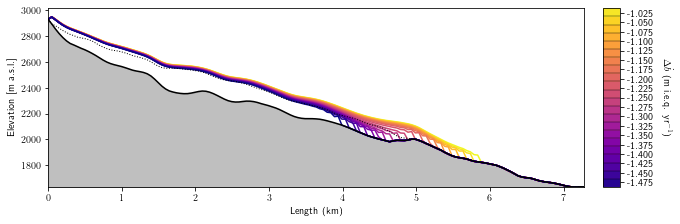

In [60]:
fig, ax = plt.subplots(1,1, figsize=(10,3),
                       constrained_layout=True)

for offset in prog_vol.Delta_MB.values: 
    color = cmap(norm(offset))
    
    
    ax.plot(prognostic.coord_1[::-1] / 1e3, 
            prognostic.sel(Delta_MB=offset).isel(t=-1, coord_2=-1).Z, 
            color = color)
    
ax.plot(prognostic.coord_1[::-1]/ 1e3, 
        prognostic.sel(Delta_MB=offset).isel(t=0, coord_2=-1).Z, 
        c='k',ls=':',lw=1,
        label=r'$z_{\rm s}(t=0)$')

ax.plot(prognostic.coord_1[::-1]/ 1e3, 
        prognostic.sel(Delta_MB=offset).isel(t=0, coord_2=-1).zbed, 
        c='k',lw=1.5,
        label=r'$z_{\rm b}$')

ax.fill_between(prognostic.coord_1[::-1]/ 1e3,
                prognostic.sel(Delta_MB=offset).isel(t=0, coord_2=-1).zbed, 
                y2=prognostic.zbed.min(),
                color='gray', alpha=0.5)

cbar = fig.colorbar(s_map,
                    spacing='proportional',
                    ticks=np.linspace(prognostic.Delta_MB.values.min(),
                                      prognostic.Delta_MB.values.max(),
                                      prognostic.Delta_MB.size),
                    ax=ax,
                    boundaries=bounds,
                    drawedges=True,
                    format='%2.{}f'.format(3),
                    aspect=35)

ax.set_ylim(prognostic.zbed.min(), None)

ax.set_xlim(prognostic.coord_1.min()/1e3, 
            prognostic.coord_1.max()/1e3)


ax.set_xlabel('Length (km)')
ax.set_ylabel('Elevation  [m a.s.l.]')
ax.set_xlim(0,np.max(prognostic.coord_1)/1000.)

cbar.set_label('$\Delta \dot b$ (m i.e.q. yr$^{-1}$)', rotation=270, labelpad=20)
#cbar.ax.tick_params(labelsize=6)

ratio = 1/3
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

fig.savefig('./figs/Zs_2kya.png', dpi=300)

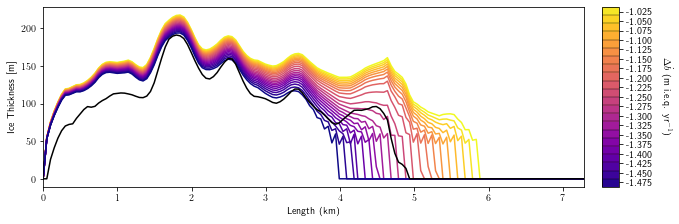

In [59]:
fig, ax = plt.subplots(1,1, figsize=(10,3),
                       constrained_layout=True)

for offset in prog_vol.Delta_MB.values: 
    color = cmap(norm(offset))
    
    
    ax.plot(prognostic.coord_1[::-1] / 1e3, 
            # prognostic.sel(Delta_MB=offset).isel(t=-1).mean('coord_2').vel_m,
            prognostic.sel(Delta_MB=offset).isel(t=-1, coord_2=-1).height,
            color = color)
    
ax.plot(prognostic.coord_1[::-1] / 1e3, 
    # prognostic.sel(Delta_MB=offset).isel(t=-1).mean('coord_2').vel_m,
    prognostic.sel(Delta_MB=offset).isel(t=0, coord_2=-1).height,
    color = 'k')


cbar = fig.colorbar(s_map,
                    spacing='proportional',
                    ticks=np.linspace(prognostic.Delta_MB.values.min(),
                                      prognostic.Delta_MB.values.max(),
                                      prognostic.Delta_MB.size),
                    ax=ax,
                    boundaries=bounds,
                    drawedges=True,
                    format='%2.{}f'.format(3),
                    aspect=35)

# ax.set_ylim(prognostic.zbed.min(), None)

ax.set_xlim(prognostic.coord_1.min()/1e3, 
            prognostic.coord_1.max()/1e3)


ax.set_xlabel('Length (km)')
ax.set_ylabel('Ice Thickness  [m]')
ax.set_xlim(0,np.max(prognostic.coord_1)/1000.)

cbar.set_label('$\Delta \dot b$ (m i.e.q. yr$^{-1}$)', rotation=270, labelpad=20)
#cbar.ax.tick_params(labelsize=6)

ratio = 1/3
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

fig.savefig('./figs/H_2kya.png', dpi=300)

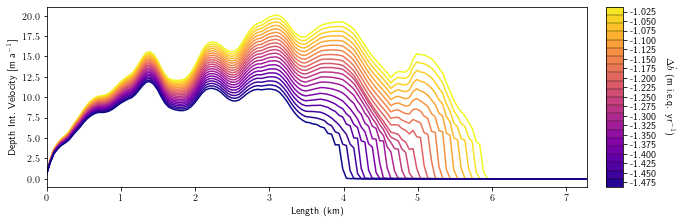

In [58]:
fig, ax = plt.subplots(1,1, figsize=(10,3),
                       constrained_layout=True)

for offset in prog_vol.Delta_MB.values: 
    color = cmap(norm(offset))
    
    
    ax.plot(prognostic.coord_1[::-1] / 1e3, 
            prognostic.sel(Delta_MB=offset).isel(t=-1).mean('coord_2').vel_m,
            color = color)


cbar = fig.colorbar(s_map,
                    spacing='proportional',
                    ticks=np.linspace(prognostic.Delta_MB.values.min(),
                                      prognostic.Delta_MB.values.max(),
                                      prognostic.Delta_MB.size),
                    ax=ax,
                    boundaries=bounds,
                    drawedges=True,
                    format='%2.{}f'.format(3),
                    aspect=35)

# ax.set_ylim(prognostic.zbed.min(), None)

ax.set_xlim(prognostic.coord_1.min()/1e3, 
            prognostic.coord_1.max()/1e3)


ax.set_xlabel('Length (km)')
ax.set_ylabel('Depth Int. Velocity  [m a$^{-1}$]')
ax.set_xlim(0,np.max(prognostic.coord_1)/1000.)

cbar.set_label('$\Delta \dot b$ (m i.e.q. yr$^{-1}$)', rotation=270, labelpad=20)
#cbar.ax.tick_params(labelsize=6)

ratio = 1/3
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

fig.savefig('./figs/Vm_2kya.png', dpi=300)

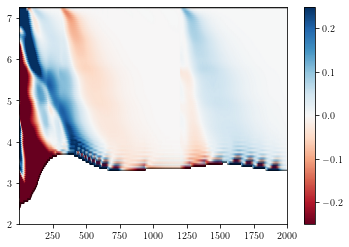

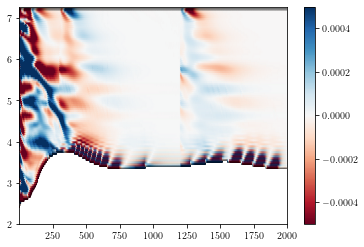

In [50]:
plt.rcParams.update({'text.usetex': True})


# Ice thickness [m]
H   = prognostic.height.where(prognostic.height > 0).isel(coord_2=-1)
# Bed Elevation [m a.s.l.]
z_b = prognostic.zbed.where(prognostic.height > 0).isel(coord_2=-1)
# Surface Slope [-]
α   = H.differentiate("coord_1")
# Bed Slope [-]
β   = z_b.differentiate("coord_1")
# Ice Density [kg m^-3]
ρ   = 910.0
# Gravitational constant [m s^{-2}]
g   = 9.81


fig, ax = plt.subplots()

im = ax.pcolormesh(prognostic.t, 
                   prognostic.coord_1/1e3,
                   H.isel(Delta_MB=-1).differentiate("t").T,
                   shading='gouraud',
                   vmin=-0.25, vmax=0.25,
                   cmap='RdBu',

             )

ax.set_ylim(2, prognostic.coord_1.max()/1e3)
fig.colorbar(im)

fig.savefig("/Users/andrewnolan/Desktop/DH_Dt.png", dpi=400)



fig, ax = plt.subplots()

im = ax.pcolormesh(prognostic.t, 
                   prognostic.coord_1/1e3,
                   (ρ * g * H.isel(Delta_MB=-1) * α.isel(Delta_MB=-1) / 1e6).differentiate("t").T,
                   shading='gouraud',
                   vmin=-0.0005, vmax=0.0005, 
                   cmap='RdBu',
                  )

ax.set_ylim(2, prognostic.coord_1.max()/1e3)
fig.colorbar(im)

fig.savefig("/Users/andrewnolan/Desktop/Dtau_Dt.png", dpi=400)

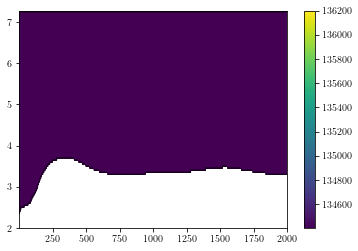

In [51]:
fig, ax = plt.subplots()

im = ax.pcolormesh(prognostic.t, 
                   prognostic.coord_1/1e3,
                   prognostic.enthalpy_h.where(prognostic.height > 0).isel(Delta_MB=-1).isel(coord_2=-1).T,#.differentiate("t").T,
                   shading='gouraud',
                   # vmin=-0.001, vmax=0.001, 
                   # cmap='RdBu',
                   vmin=136200, 
                   # vmax=0.25
             )

ax.set_ylim(2, prognostic.coord_1.max()/1e3)
fig.colorbar(im)

In [ ]:
prognostic['mass balance']

In [ ]:
# plt.plot(prognostic.coord_1, 
#          prognostic['surface_enthalpy'].isel(Delta_MB=-1, t=-2).isel(coord_2=-1))

plt.plot(prognostic.coord_2, 
         prognostic['surface_enthalpy'].isel(Delta_MB=-1, t=1).isel(coord_1=-1), 'x-')


In [ ]:
# plt.imshow(prognostic['surface_enthalpy'].isel(Delta_MB=0,t=-10))


fig, ax = plt.subplots()

im = ax.pcolormesh(prognostic.t, 
                   prognostic.coord_1/1e3,
                   prognostic['surface_enthalpy'].isel(Delta_MB=0,t=-10),#.differentiate("t").T,
                   shading='gouraud',
                   # vmin=-0.001, vmax=0.001, 
                   # cmap='RdBu',
                   vmin=134404, 
                   vmax=136218,
                   # vmax=0.25
             )

In [52]:
import importlib
import animate_Zs

importlib.reload(animate_Zs)
plt.rcParams.update({'text.usetex': True})


In [53]:
mb_index = 0 
Delta_mb = float(prognostic.Delta_MB[mb_index].values)

fig, anim = animate_Zs.animate_2D_field(prognostic.isel(Delta_MB=mb_index), 
                                        field=["vel_m", "temperature"],
                                        title="$\Delta \dot b$ = {:.3f}".format(Delta_mb),
                                        cbar_label=['Velocity [m a$^{-1}$]', 'Temperature [C]'],
                                        vmin=[0, -12.5], 
                                        vmax=[25, 0.0], 
                                        cmap=['viridis', 'plasma'],
                                        stride=10, 
                                        interval=100)

plt.close()

anim.save(f'./figs/Delta_b{Delta_mb}_anim.mp4')

In [54]:
mb_index = -1 
Delta_mb = float(prognostic.Delta_MB[mb_index].values)

fig, anim = animate_Zs.animate_2D_field(prognostic.isel(Delta_MB=mb_index), 
                                        field=["vel_m", "temperature"],
                                        title="$\Delta \dot b$ = {:.3f}".format(Delta_mb),
                                        cbar_label=['Velocity [m a$^{-1}$]', 'Temperature [C]'],
                                        vmin=[0, -12.5], 
                                        vmax=[25, 0.0], 
                                        cmap=['viridis', 'plasma'],
                                        stride=10, 
                                        interval=100)

plt.close()

anim.save(f'./figs/Delta_b{Delta_mb}_anim.mp4')

In [ ]:
fig, anim = animate_Zs.animate_2D_field(prognostic.isel(Delta_MB=0), 
                                        field="water content",
                                        title="$\Delta \dot b$ = {:.3f}".format(float(prognostic.Delta_MB[0].values)), 
                                        stride=10, 
                                        interval=100, 
                                        vmin=0,
                                        vmax=3)

plt.close()

anim.save('./figs/watercont_anim.mp4')

In [ ]:
# prog_perc.sel(delta_MB=offset)[:-1].rolling(t=5).mean()

In [ ]:
fps = '/Volumes/thermal/Thesis/thermal-structure/study/coupled_init/glc1-a/nc/glc1-a_dx_50_*_OFF_diag.nc'
westgrid = load_diagnostic(fps)

fps = 'glc1-a/nc/glc1-a_dx_50_MB_*_OFF_Tma_-9.02_diag.nc'
localrun_m9 = load_diagnostic(fps)
t_f9 = find_Tf(localrun_m9.Z.isel(coord_1=-1, coord_2=-1))

fps = 'glc1-a/nc/glc1-a_dx_50_MB_*_OFF_Tma_-8.02_diag.nc'
localrun_m8 = load_diagnostic(fps)
t_f8 = find_Tf(localrun_m8.Z.isel(coord_1=-1, coord_2=-1))


In [ ]:
plt.pcolormesh(localrun_m9.X.isel(Delta_MB=0)[::-1], 
               localrun_m9.Z.isel(t=5, Delta_MB=0), 
               localrun_m9['temperature'].isel(t=5, Delta_MB=0), 
               shading='gouraud', )

plt.colorbar()

In [ ]:
plt.plot(localrun_m9.coord_1[::-1], localrun_m9['surface_enthalpy'].isel(t=5,Delta_MB=0,coord_2=-1))

In [ ]:
cd

In [ ]:
fig, ax = plt.subplots()

for offset in localrun_m9.delta_MB: 
    t_i9 = t_f9.sel(delta_MB=offset).values
    t_i8 = t_f8.sel(delta_MB=offset).values
    
    ax.scatter(offset, 
               localrun_m9.temperature.sel(t=t_i9).sel(delta_MB=offset).mean(('coord_1', 'coord_2')),
               marker='x', color='tab:blue')

    ax.scatter(offset, 
               localrun_m8.temperature.sel(t=t_i8).sel(delta_MB=offset).mean(('coord_1', 'coord_2')),
               marker='o', color='tab:blue')
    
    
# for offset in westgrid.delta_MB: 
#     # t_i = t_f.sel(delta_MB=offset)
#     ax.scatter(offset, 
#                westgrid.temperature.isel(t=-1).sel(delta_MB=offset).mean(('coord_1', 'coord_2')),
#                marker='o', color='tab:blue')

In [ ]:
localrun.delta_MB == -1.0

In [ ]:
# src = xr.open_mfdataset('glc1-a/nc/glc1-a_dx_50_*_OFF_diag.nc',
#                         concat_dim="delta_MB", combine="nested",
#                         data_vars='minimal', coords='minimal', compat='override')

# # correct for minimum ice thickness
# src["height"] = xr.where(src.height <= 10, 0, src.height)
# src["Z"]     = src.zbed + src.Z * src.height 
# src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)


with xr.open_dataset('glc1-a/nc/glc1-a_dx_50_-1.000_OFF_diag.nc') as src: 
    src["height"] = xr.where(src.height <= 10, 0, src.height)
    src["Z"]     = src.zbed + src.Z * src.height 
    src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)
    
    src = src.drop_dims('delta_MB')
    
    